# Lexical network analysis

## Loading

In [19]:
### Initialisation of the absolute Github repository path :

from pathlib import Path
import sys

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


### Import data prepared
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(f"Data preparation folder detected at: {DATA_PREPARATION_PY_PATH.resolve()}")

Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
Data preparation folder detected at: C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


In [20]:
# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle


# classic librairies
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# text processing librairies
from sklearn.feature_extraction.text import CountVectorizer

# statistical libraries
import networkx as nx


In [21]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)


### Loading of preprocessed data's pickle :
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

## Lexical network out of the captions

In [22]:
caption_idx = contest_index2absolute_index(801)

<br/><br/>
<center>
    <img src="../../data/newyorker_caption_contest_virgin/images/801.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

In [23]:
lemmatized_data['dataA'][caption_idx].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,cleaned_caption
rank,,,,,,,,
0,What do you mean I don’t have time for another...,1.749541,0.014062,3270,1569,951,750,mean time another game
1,Hah. Now it’s only taxes.,1.727380,0.019434,1691,833,486,372,tax
2,Well I’ll be damned.,1.711446,0.020791,1459,731,418,310,well damned
3,Grim loser is more like it.,1.705473,0.017322,2010,989,624,397,grim lower like
4,Leonard soon learns what it means to win the b...,1.699871,0.020571,1546,807,396,343,leopard soon learns mean win battle lose war


Taxes ? why do they talk about taxes and why is it funny ?\
grim loser ?\
Leonard ?

In [24]:
def build_lexical_network(caption_list):
    """
    Build a lexical network based on co-occurrence of words in captions.
    """
    # Tokenize: split each caption into words
    tokenized_captions = [c.split() for c in caption_list if isinstance(c, str) and c.strip()]

    # Build co-occurrence matrix
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    X = vectorizer.fit_transform(tokenized_captions)
    vocab = vectorizer.get_feature_names_out()

    cooccurrence = (X.T @ X).toarray()  # co-occurrence count matrix
    np.fill_diagonal(cooccurrence, 0)  # remove self-loops

    # Build graph
    G = nx.Graph()
    for i, word1 in enumerate(vocab):
        for j, word2 in enumerate(vocab):
            if cooccurrence[i, j] > 0:
                G.add_edge(word1, word2, weight=cooccurrence[i, j])
    
    return G

def plot_lexical_network(G, top_n=30):
    """
    Plot the lexical network, optionally focusing on top_n nodes by degree.
    """
    # Select top_n nodes by degree
    degrees = dict(G.degree(weight='weight'))
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)

    pos = nx.spring_layout(H, seed=42, k=0.5, iterations=50)
    
    # Node sizes proportional to weighted degree
    sizes = [degrees[n]*10 for n in H.nodes()]
    
    # Edge widths proportional to co-occurrence
    weights = [H[u][v]['weight']/5 for u,v in H.edges()]

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(H, pos, width=weights, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')
    
    plt.title("Lexical Network of Captions (Top Words by Co-occurrence)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


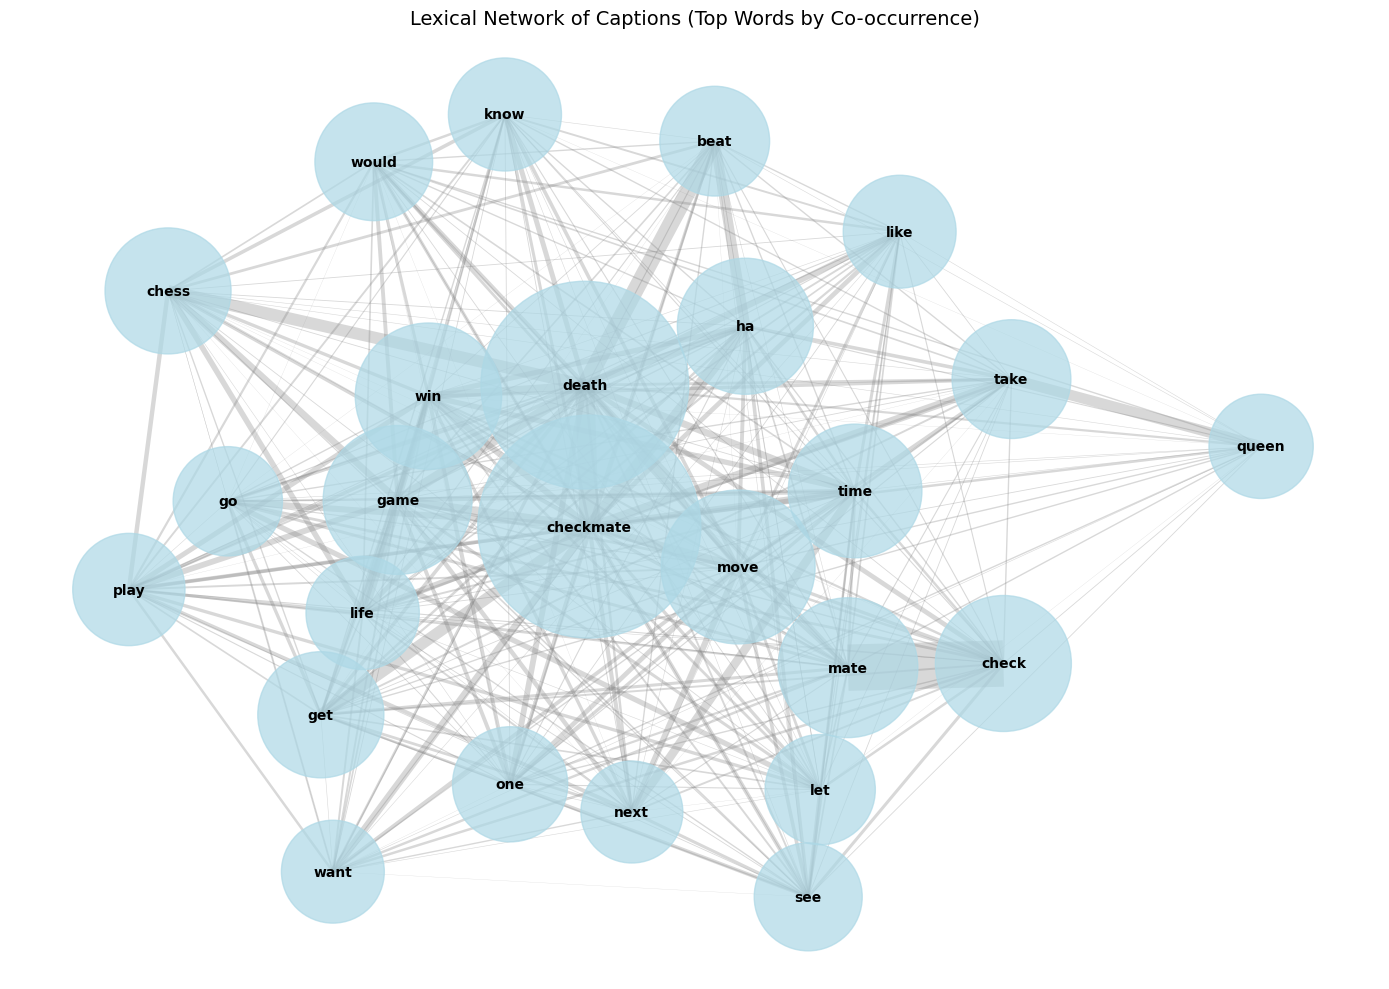

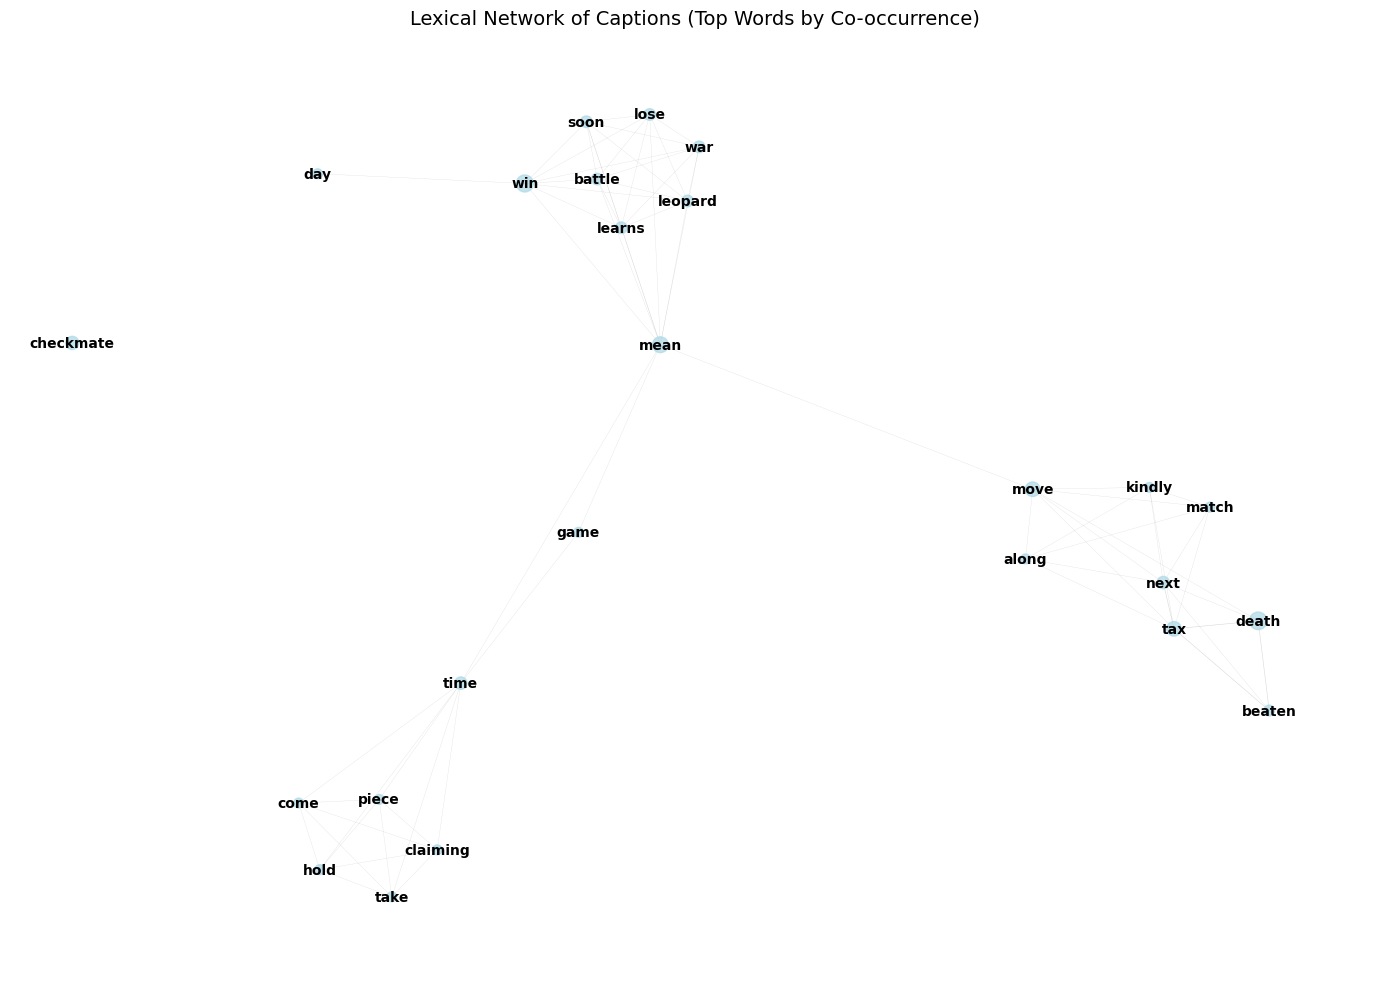

In [25]:
# pour un seul contest:
captions = lemmatized_data['dataA'][caption_idx]['cleaned_caption'].tolist()
G = build_lexical_network(captions)
plot_lexical_network(G, top_n=25)

# les 25 meilleurs de ce contest:
captions = lemmatized_data['dataA'][caption_idx]['cleaned_caption'][:25].tolist()
G = build_lexical_network(captions)
plot_lexical_network(G, top_n=25)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def build_lexical_network_tfidf(caption_list, idf_weight=0.5, min_tfidf=0.0):
    """
    Build a lexical network based on co-occurrence of words weighted by TF-IDF.
    
    Parameters:
    -----------
    caption_list : list
        List of captions (strings with space-separated words)
    idf_weight : float (0 to 1)
        How much to weight IDF vs raw co-occurrence. 
        0 = only co-occurrence, 1 = only TF-IDF
    min_tfidf : float
        Minimum TF-IDF score for a word to be included in the network
    """
    # Tokenize: split each caption into words
    tokenized_captions = [c.split() for c in caption_list if isinstance(c, str) and c.strip()]
    
    # Join back for TF-IDF (it expects strings)
    caption_strings = [' '.join(tokens) for tokens in tokenized_captions]

    # Build TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
    X_tfidf = tfidf_vectorizer.fit_transform(caption_strings)
    vocab = tfidf_vectorizer.get_feature_names_out()
    
    # Get IDF scores for each word
    idf_scores = dict(zip(vocab, tfidf_vectorizer.idf_))
    
    # Build co-occurrence matrix (raw counts)
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
    X_count = count_vectorizer.fit_transform(caption_strings)
    
    cooccurrence = (X_count.T @ X_count).toarray()
    np.fill_diagonal(cooccurrence, 0)
    
    # Calculate mean TF-IDF score for each word across all documents
    mean_tfidf = np.array(X_tfidf.mean(axis=0)).flatten()
    word_tfidf_scores = dict(zip(vocab, mean_tfidf))
    
    # Build graph with weighted edges
    G = nx.Graph()
    
    for i, word1 in enumerate(vocab):
        # Filter out words with low TF-IDF
        if word_tfidf_scores[word1] < min_tfidf:
            continue
            
        for j, word2 in enumerate(vocab):
            if i >= j:  # Avoid duplicates and self-loops
                continue
            
            if word_tfidf_scores[word2] < min_tfidf:
                continue
                
            if cooccurrence[i, j] > 0:
                # Weight edge by co-occurrence AND average IDF of the two words
                raw_cooccurrence = cooccurrence[i, j]
                avg_idf = (idf_scores[word1] + idf_scores[word2]) / 2
                
                # Combine co-occurrence with IDF weighting
                weighted_score = (1 - idf_weight) * raw_cooccurrence + idf_weight * raw_cooccurrence * avg_idf
                
                G.add_edge(word1, word2, 
                          weight=weighted_score,
                          raw_cooccurrence=raw_cooccurrence,
                          avg_idf=avg_idf)
    
    # Add node attributes (TF-IDF scores)
    nx.set_node_attributes(G, word_tfidf_scores, 'tfidf')
    nx.set_node_attributes(G, idf_scores, 'idf')
    
    return G

def plot_lexical_network_tfidf(G, top_n=30, size_metric='tfidf'):
    """
    Plot the lexical network, focusing on top_n nodes.
    
    Parameters:
    -----------
    G : networkx.Graph
        The lexical network
    top_n : int
        Number of top nodes to display
    size_metric : str
        Metric to use for node sizing: 'tfidf', 'degree', or 'idf'
    """
    # Get node metrics
    if size_metric == 'tfidf':
        scores = nx.get_node_attributes(G, 'tfidf')
    elif size_metric == 'idf':
        scores = nx.get_node_attributes(G, 'idf')
    else:  # degree
        scores = dict(G.degree(weight='weight'))
    
    # Select top_n nodes by the chosen metric
    top_nodes = sorted(scores, key=scores.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)
    
    if len(H.nodes()) == 0:
        print("No nodes to display")
        return

    pos = nx.spring_layout(H, seed=42, k=0.5, iterations=50)
    
    # Node sizes proportional to TF-IDF or degree
    sizes = [scores[n] * 1000 for n in H.nodes()]
    
    # Edge widths proportional to weighted co-occurrence
    weights = [H[u][v]['weight'] / max(1, np.percentile([e[2]['weight'] for e in H.edges(data=True)], 75)) 
               for u, v in H.edges()]
    
    # Color nodes by IDF (discriminative power)
    idf_values = [nx.get_node_attributes(G, 'idf').get(n, 1) for n in H.nodes()]
    
    plt.figure(figsize=(14, 10))
    
    # Draw nodes with color mapping
    nodes = nx.draw_networkx_nodes(H, pos, node_size=sizes, 
                                    node_color=idf_values, 
                                    cmap='YlOrRd', alpha=0.7,
                                    vmin=min(idf_values), vmax=max(idf_values))
    
    nx.draw_networkx_edges(H, pos, width=weights, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold', verticalalignment = "bottom")
    
    # Add colorbar
    plt.colorbar(nodes, label='IDF Score (Discriminative Power)', shrink=0.8)
    
    plt.title(f"Lexical Network of Captions (Top {top_n} Words by {size_metric.upper()})", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

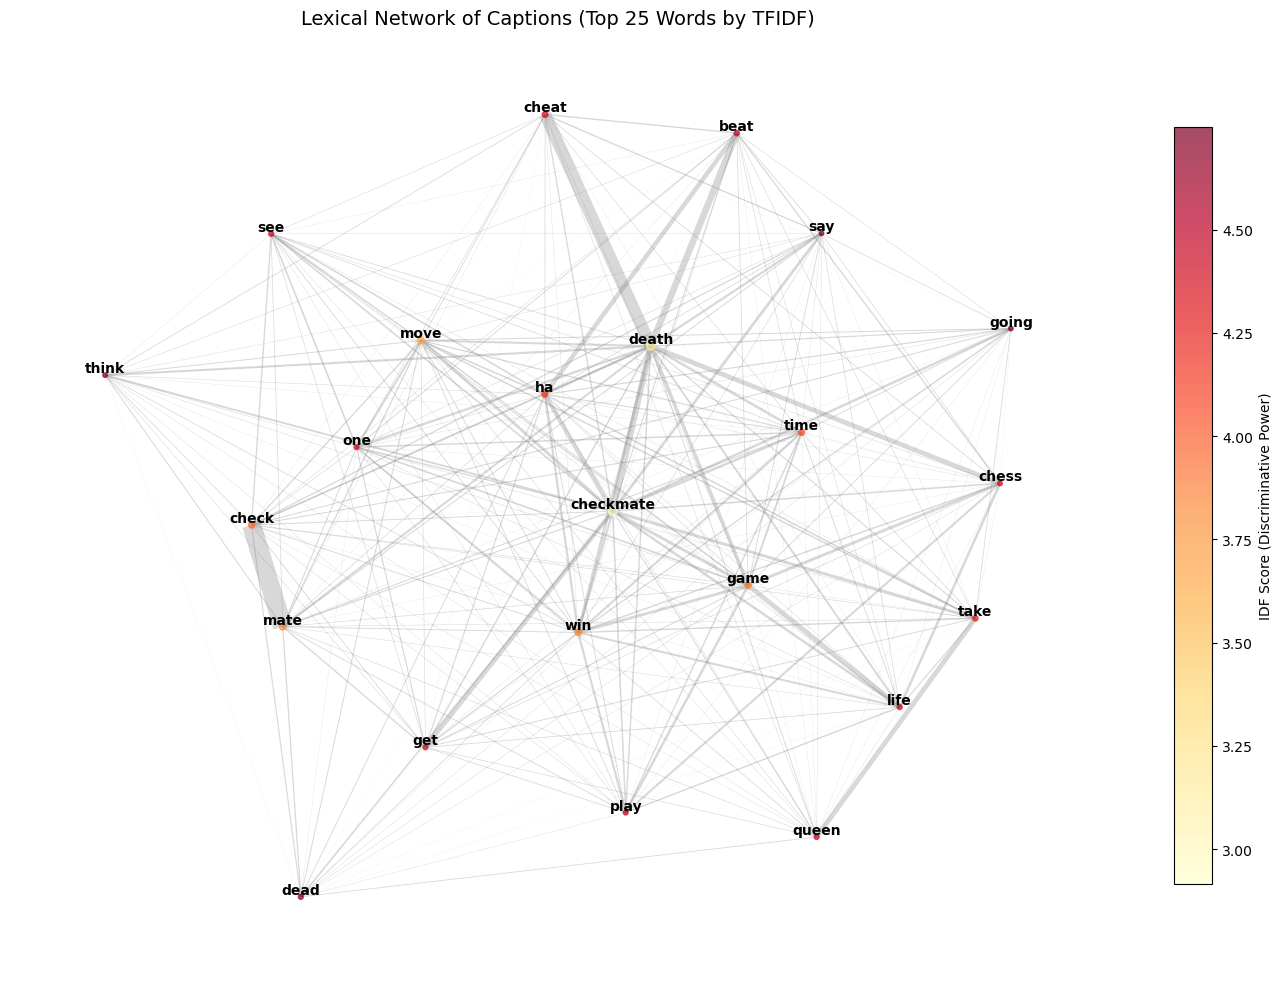

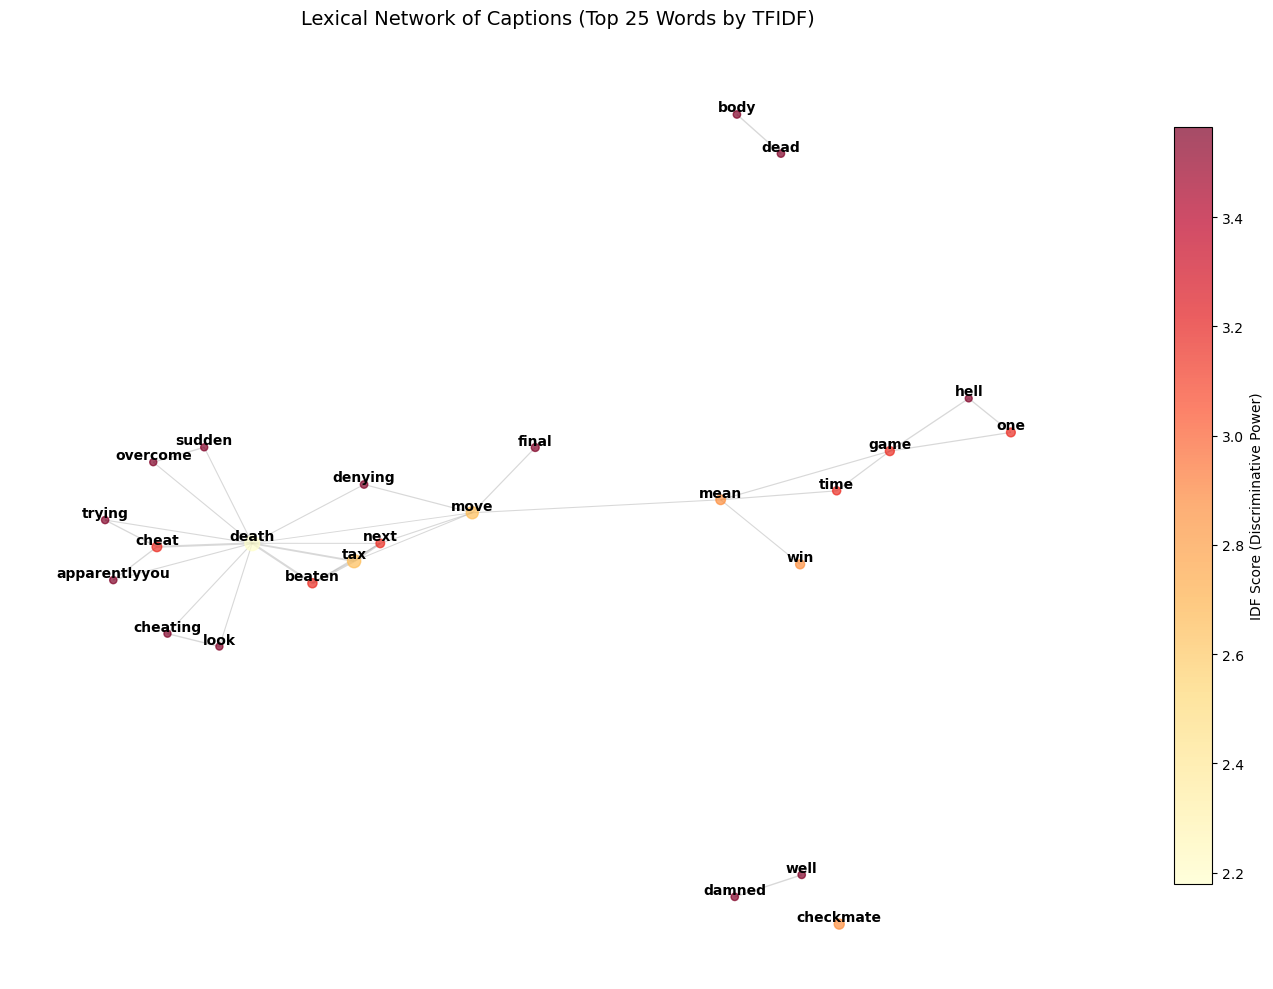

In [27]:
### pour un seul contest:
captions = lemmatized_data['dataA'][caption_idx]['cleaned_caption'].tolist()
# Plus de poids sur IDF (mots discriminants)
G_idf_heavy = build_lexical_network_tfidf(captions, idf_weight=1, min_tfidf=0.01)
plot_lexical_network_tfidf(G_idf_heavy, top_n=25, size_metric='tfidf')



### les 25 meilleurs de ce contest:
captions = lemmatized_data['dataA'][caption_idx]['cleaned_caption'][:25].tolist()
# Plus de poids sur IDF (mots discriminants)
G_idf_heavy = build_lexical_network_tfidf(captions, idf_weight=1, min_tfidf=0.01)
plot_lexical_network_tfidf(G_idf_heavy, top_n=25, size_metric='tfidf')

## On va essayer de comparer les resultats entre eux !
- Comparaison visuelle : Deux réseaux côte à côte pour voir les différences de structure
- Mots distinctifs : Quels mots apparaissent plus dans les top captions vs le reste
- Statistiques de réseau : Densité, connectivité, etc.
- Test statistique : Mann-Whitney U test pour voir si la différence est significative
- Distribution TF-IDF : Visualisation des distributions de scores

In [28]:
def compare_top_vs_rest(contest_data, top_n=50, network_size=30, idf_weight=0.7):
    """
    Compare lexical networks of top-rated captions vs the rest.
    
    Parameters:
    -----------
    contest_data : DataFrame
        Contest data with 'cleaned_caption' and 'mean' columns
    top_n : int
        Number of top captions to compare
    network_size : int
        Number of nodes to display in each network
    idf_weight : float
        Weight for IDF in network construction
    """
    # Sort by mean rating
    sorted_data = contest_data.sort_values('mean', ascending=False)
    
    # Split into top and rest
    top_captions = sorted_data.head(top_n)['cleaned_caption'].tolist()
    rest_captions = sorted_data.iloc[top_n:]['cleaned_caption'].tolist()
    
    print(f"Top captions: {len(top_captions)}")
    print(f"Rest captions: {len(rest_captions)}")
    print(f"Top mean rating: {sorted_data.head(top_n)['mean'].mean():.3f}")
    print(f"Rest mean rating: {sorted_data.iloc[top_n:]['mean'].mean():.3f}")
    
    # Build networks
    G_top = build_lexical_network_tfidf(top_captions, idf_weight=idf_weight, min_tfidf=0.01)
    G_rest = build_lexical_network_tfidf(rest_captions, idf_weight=idf_weight, min_tfidf=0.01)
    
    # Get word statistics
    top_tfidf = nx.get_node_attributes(G_top, 'tfidf')
    rest_tfidf = nx.get_node_attributes(G_rest, 'tfidf')
    
    top_degree = dict(G_top.degree(weight='weight'))
    rest_degree = dict(G_rest.degree(weight='weight'))
    
    # Find distinctive words
    top_only = set(G_top.nodes()) - set(G_rest.nodes())
    rest_only = set(G_rest.nodes()) - set(G_top.nodes())
    common = set(G_top.nodes()) & set(G_rest.nodes())
    
    print(f"\n{'='*60}")
    print("VOCABULARY COMPARISON")
    print(f"{'='*60}")
    print(f"Words only in top captions: {len(top_only)}")
    print(f"Words only in rest: {len(rest_only)}")
    print(f"Common words: {len(common)}")
    
    # Find words more important in top vs rest
    importance_diff = {}
    for word in common:
        top_score = top_tfidf.get(word, 0)
        rest_score = rest_tfidf.get(word, 0)
        importance_diff[word] = top_score - rest_score
    
    print(f"\n{'='*60}")
    print("WORDS MORE IMPORTANT IN TOP CAPTIONS")
    print(f"{'='*60}")
    top_distinctive = sorted(importance_diff.items(), key=lambda x: x[1], reverse=True)[:15]
    for word, diff in top_distinctive:
        print(f"  {word:20s} | TF-IDF diff: {diff:+.4f}")
    
    print(f"\n{'='*60}")
    print("WORDS MORE IMPORTANT IN REST")
    print(f"{'='*60}")
    rest_distinctive = sorted(importance_diff.items(), key=lambda x: x[1])[:15]
    for word, diff in rest_distinctive:
        print(f"  {word:20s} | TF-IDF diff: {diff:+.4f}")
    
    # Plot side-by-side networks
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot top network
    plt.sca(axes[0])
    plot_lexical_network_comparison(G_top, top_n=network_size, 
                                     title=f"Top {top_n} Captions\n(Mean: {sorted_data.head(top_n)['mean'].mean():.3f})",
                                     ax=axes[0])
    
    # Plot rest network
    plt.sca(axes[1])
    plot_lexical_network_comparison(G_rest, top_n=network_size,
                                     title=f"Rest of Captions\n(Mean: {sorted_data.iloc[top_n:]['mean'].mean():.3f})",
                                     ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'G_top': G_top,
        'G_rest': G_rest,
        'top_only': top_only,
        'rest_only': rest_only,
        'common': common,
        'importance_diff': importance_diff
    }

def plot_lexical_network_comparison(G, top_n=30, title="", ax=None):
    """
    Plot lexical network on a specific axis for comparison.
    """
    if ax is None:
        ax = plt.gca()
    
    scores = nx.get_node_attributes(G, 'tfidf')
    if not scores:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        ax.axis('off')
        return
    
    top_nodes = sorted(scores, key=scores.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)
    
    if len(H.nodes()) == 0:
        ax.text(0.5, 0.5, 'No nodes', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        ax.axis('off')
        return

    pos = nx.spring_layout(H, seed=42, k=0.5, iterations=50)
    
    sizes = [scores[n] * 1000 for n in H.nodes()]
    weights = [H[u][v]['weight'] / max(1, np.percentile([e[2]['weight'] for e in H.edges(data=True)], 75)) 
               for u, v in H.edges()]
    
    idf_values = [nx.get_node_attributes(G, 'idf').get(n, 1) for n in H.nodes()]
    
    nodes = nx.draw_networkx_nodes(H, pos, node_size=sizes, 
                                    node_color=idf_values, 
                                    cmap='YlOrRd', alpha=0.7,
                                    vmin=min(idf_values) if idf_values else 0, 
                                    vmax=max(idf_values) if idf_values else 1,
                                    ax=ax)
    
    nx.draw_networkx_edges(H, pos, width=weights, alpha=0.3, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(H, pos, font_size=9, font_weight='bold', ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# Analyse statistique plus poussée
def statistical_comparison(comparison_results, alpha=0.05):
    """
    Perform statistical tests on the lexical differences.
    """
    G_top = comparison_results['G_top']
    G_rest = comparison_results['G_rest']
    
    # Network metrics
    print(f"\n{'='*60}")
    print("NETWORK STATISTICS")
    print(f"{'='*60}")
    
    metrics = {
        'Number of nodes': (len(G_top.nodes()), len(G_rest.nodes())),
        'Number of edges': (len(G_top.edges()), len(G_rest.edges())),
        'Average degree': (np.mean(list(dict(G_top.degree()).values())), 
                          np.mean(list(dict(G_rest.degree()).values()))),
        'Network density': (nx.density(G_top), nx.density(G_rest)),
    }
    
    for metric, (top_val, rest_val) in metrics.items():
        print(f"{metric:25s} | Top: {top_val:8.2f} | Rest: {rest_val:8.2f} | Diff: {top_val - rest_val:+8.2f}")
    
    # TF-IDF distribution comparison
    top_tfidf_values = list(nx.get_node_attributes(G_top, 'tfidf').values())
    rest_tfidf_values = list(nx.get_node_attributes(G_rest, 'tfidf').values())
    
    if len(top_tfidf_values) > 0 and len(rest_tfidf_values) > 0:
        from scipy import stats
        
        # Mann-Whitney U test (non-parametric)
        statistic, p_value = stats.mannwhitneyu(top_tfidf_values, rest_tfidf_values, alternative='two-sided')
        
        print(f"\n{'='*60}")
        print("STATISTICAL TEST: TF-IDF Distribution")
        print(f"{'='*60}")
        print(f"Mann-Whitney U statistic: {statistic:.2f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Significant difference: {'YES' if p_value < alpha else 'NO'} (α={alpha})")
        
        # Distribution comparison plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(top_tfidf_values, bins=30, alpha=0.6, label='Top captions', color='blue')
        plt.hist(rest_tfidf_values, bins=30, alpha=0.6, label='Rest', color='orange')
        plt.xlabel('TF-IDF Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('TF-IDF Distribution Comparison')
        
        plt.subplot(1, 2, 2)
        plt.boxplot([top_tfidf_values, rest_tfidf_values], labels=['Top', 'Rest'])
        plt.ylabel('TF-IDF Score')
        plt.title('TF-IDF Distribution (Boxplot)')
        
        plt.tight_layout()
        plt.show()

Top captions: 25
Rest captions: 4440
Top mean rating: 1.666
Rest mean rating: 1.263

VOCABULARY COMPARISON
Words only in top captions: 59
Words only in rest: 12
Common words: 11

WORDS MORE IMPORTANT IN TOP CAPTIONS
  death                | TF-IDF diff: +0.0775
  move                 | TF-IDF diff: +0.0519
  cheat                | TF-IDF diff: +0.0316
  one                  | TF-IDF diff: +0.0287
  game                 | TF-IDF diff: +0.0224
  win                  | TF-IDF diff: +0.0216
  time                 | TF-IDF diff: +0.0163
  dead                 | TF-IDF diff: +0.0159
  checkmate            | TF-IDF diff: +0.0106
  going                | TF-IDF diff: +0.0068
  take                 | TF-IDF diff: +0.0021

WORDS MORE IMPORTANT IN REST
  take                 | TF-IDF diff: +0.0021
  going                | TF-IDF diff: +0.0068
  checkmate            | TF-IDF diff: +0.0106
  dead                 | TF-IDF diff: +0.0159
  time                 | TF-IDF diff: +0.0163
  win             

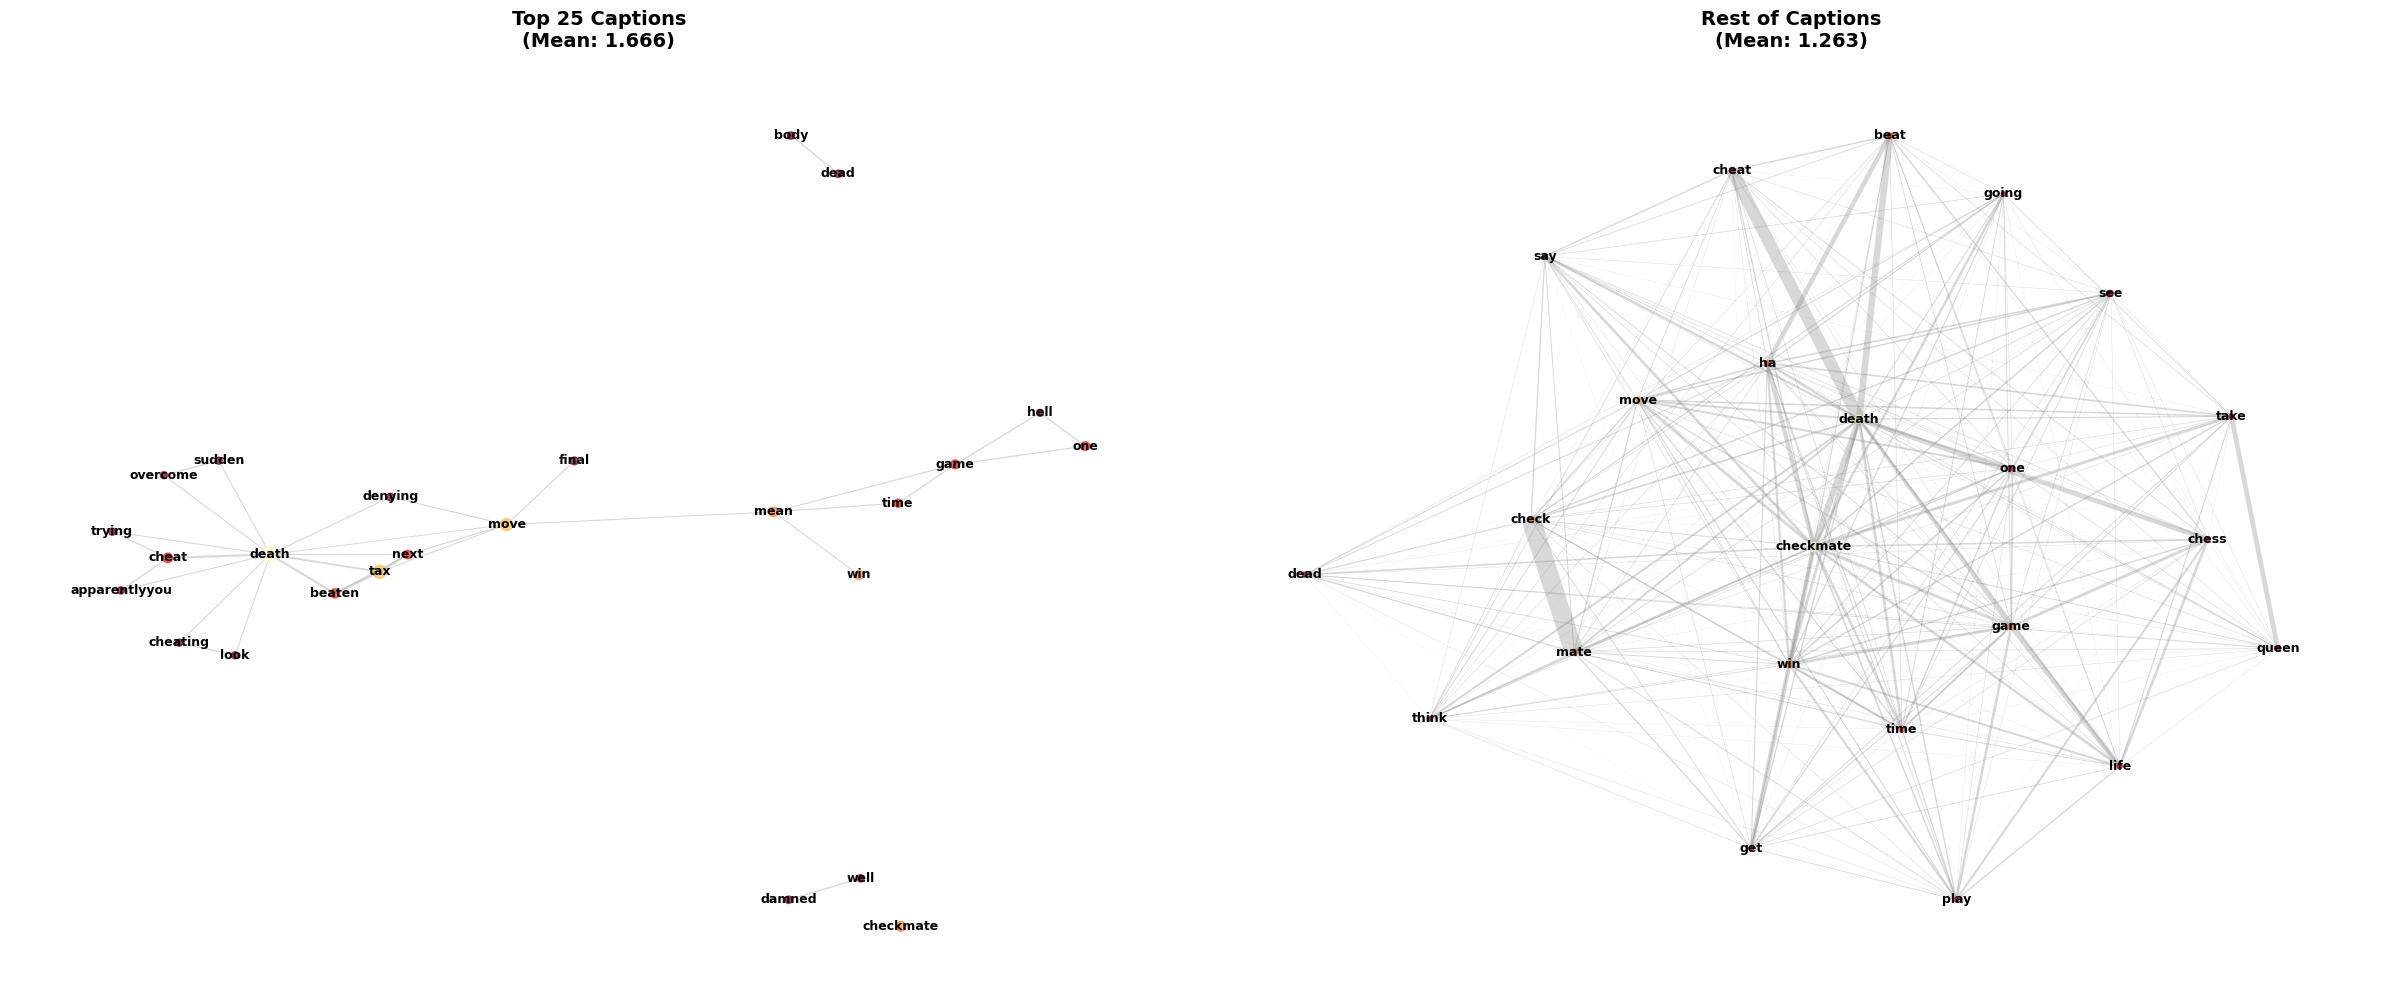


NETWORK STATISTICS
Number of nodes           | Top:    70.00 | Rest:    23.00 | Diff:   +47.00
Number of edges           | Top:   153.00 | Rest:   242.00 | Diff:   -89.00
Average degree            | Top:     4.37 | Rest:    21.04 | Diff:   -16.67
Network density           | Top:     0.06 | Rest:     0.96 | Diff:    -0.89

STATISTICAL TEST: TF-IDF Distribution
Mann-Whitney U statistic: 1296.00
P-value: 0.0000
Significant difference: YES (α=0.05)


C:\Users\cyrie\AppData\Local\Temp\ipykernel_6152\2325578637.py:196: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([top_tfidf_values, rest_tfidf_values], labels=['Top', 'Rest'])


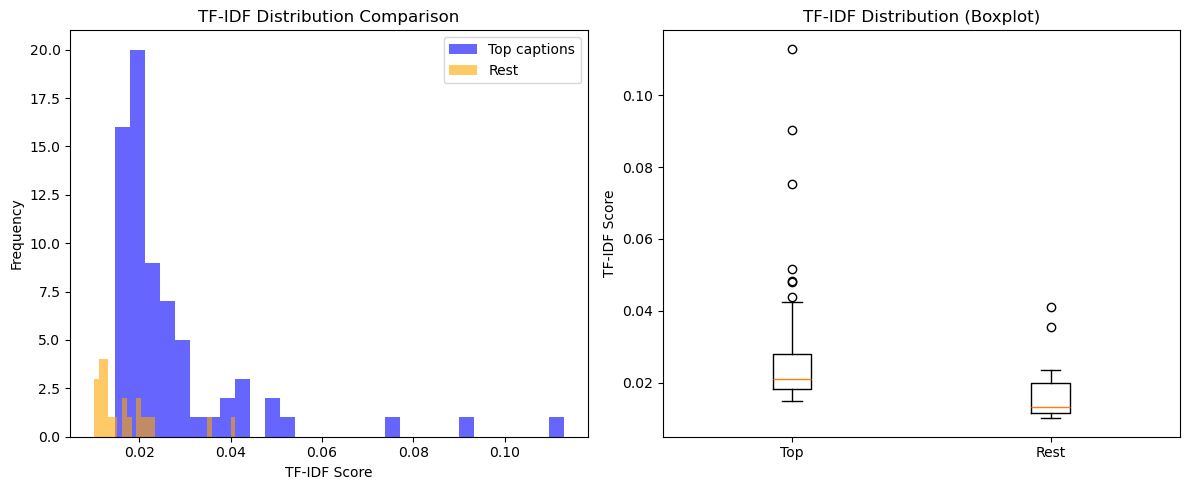

In [29]:
# Utilisation
contest_data = lemmatized_data['dataA'][caption_idx]

# Comparer top 50 vs reste
results = compare_top_vs_rest(contest_data, top_n=25, network_size=25, idf_weight=1)

# Analyse statistique
statistical_comparison(results)

## et entre tous les contests ?